> # Trading Strategies using Machine Learning
---

### Tesla Stock statistics, Feature Construction (scraping or APIs), and Feature selection using Regression based and Tree based (Bagging and Boosting) Machine Learning models.
---

- Focus on the stock (TESLA) and their competitors. Report summary statistics of the training period you select and plot the kernel density. 
- Use the features/factors you  take and discovered (e.g. FRED, Fama-French website, ADS, AR, CAPM, momentum factors, volume, price/return lags, etc.) to construct a feature database. The target variable Y can be either price or return. Frequency could be either daily or monthly.    
- Virtualize the feature importance and feature selection process using regression based approach (Ridge regression, LASSO, Elastic Net or LARS) vs decision tree based approach (random forest, XGBoost). 

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
from fredapi import Fred
from functools import reduce
from pandas_datareader import DataReader
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn import linear_model
import xgboost
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

> ### Summary statistics and kernel density estimation plot of tesla and it's competitors
---

[*********************100%%**********************]  4 of 4 completed


  Ticker        Mean      Variance  Skewness  Kurtosis
0     GM   38.114907     86.225083  0.902622  3.319639
1    HMC   26.617214      9.798446  0.295067  2.489081
2     TM  146.121816    483.301057  0.664098  2.351239
3   TSLA  145.981504  12880.563046  0.174758  1.603995


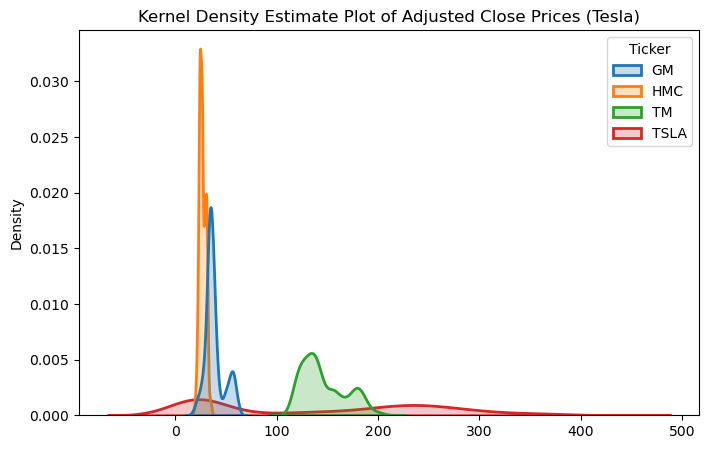

In [2]:
start_date = datetime(2018,1,1)
end_date = datetime(2023,12,31)
ticker = ['TSLA','GM','TM','HMC']   # Toyota Motor (TM), Ford Motor (F), General Motors (GM)

def get_stock_data(ticker,start_date=start_date,end_date=end_date):
    data = yf.download(ticker,start_date,end_date)
    return data['Adj Close']

# get historical price
price_data = get_stock_data(ticker,start_date,end_date)

summary_stats = {
    'Ticker': price_data.columns[0:],  
    'Mean': [np.mean(price_data[col]) for col in price_data.columns[0:]],
    'Variance': [np.var(price_data[col]) for col in price_data.columns[0:]],
    'Skewness': [pd.Series(price_data[col]).skew() for col in price_data.columns[0:]],
    'Kurtosis': [pd.Series(price_data[col]).kurt() + 3 for col in price_data.columns[0:]] 
}

df=pd.DataFrame(data=summary_stats)
print(df)

# KDE plot for adjusted close price
fig=plt.figure(figsize=(8,5))
sns.kdeplot(data=price_data,linewidth=2,shade=True)
plt.title('Kernel Density Estimate Plot of Adjusted Close Prices (Tesla)');

### In summary, the statistics suggest that Tesla's stock returns exhibit some level of volatility and asymmetry.

The statistics provided for the stock TSLA (Tesla) offer insights into its return distribution:

Mean: The mean return for Tesla is 145.98, which represents the average adjusted close price over the time frame.

Variance: The variance of 12,880.56 quantifies the spread or dispersion of the adjusted close prices around the 
mean. A higher variance indicates more significant fluctuations or volatility.

Skewness: The skewness of 0.17 signifies that Tesla's stock price distribution has a slight rightward tilt. This suggests that there's a slightly higher likelihood of positive spikes or that positive deviations from the mean may be more pronounced compared to negative deviations.

Kurtosis: The kurtosis of 1.60 is slightly below the normal distribution's kurtosis of 3, indicating thinner tails. This implies fewer extreme values and a distribution that is less prone to outliers.


In summary, these statistics suggest that while Tesla's adjusted close prices show considerable volatility, the distribution has a slight tendency for positive returns, with a lower frequency of extreme values.


> ### Features/Factors construction
---

In [3]:
# 1. FAMA-FRENCH 5 FACTORS
# Get the Fama French 5 factor model (monthly data)
data_ff5 = pd.read_csv('//Users//rahulodedra//Downloads//ML in Finance//F-F_Research_Data_5_Factors_daily.CSV')
data_ff5['date'] = data_ff5['date'].astype(str).str[0:4]+'-'\
                    +data_ff5['date'].astype(str).str[4:6]+'-'\
                    +data_ff5['date'].astype(str).str[6:8]
                    
data_ff5['date'] = pd.to_datetime(data_ff5['date'])
# data_ff5['date'] = data_ff5['date'].dt.date
df_ffs = data_ff5.set_index('date')

# 2. ADS INDEX
data_ads = pd.read_excel('//Users//rahulodedra//Downloads//ML in Finance//ADS_Index_Most_Current_Vintage.xlsx')
data_ads['date']=pd.to_datetime(data_ads['date'])
df_ads = data_ads.set_index('date')

# 3. FRED DATA
fred = Fred(api_key='********************')   # generate unique api key from Fred Economic Data
varList = ['T10Y3M', 'OBMMIJUMBO30YF',  # term premium 10yr-3mon, 30 yr mortgage jumbo loan
           'DEXUSEU', 'DEXJPUS', 'DEXUSUK', # spot exchange rates to EUR, JPY, GBP 
           'CBBTCUSD', 'CBETHUSD',  # cryptocurrencies
               'T10YIE', 'DCOILBRENTEU', # breakeven inflation + brent oil price 
               'VIXCLS', # implied volatilities
               'DAAA', 'DBAA', # corporate bond yield
               'AMERIBOR', 'T10YIE', 'T5YIE', 'BAMLH0A0HYM2','BAMLH0A0HYM2EY', 
                              'DGS10', 'DGS1', 'RIFSPPFAAD90NB', 'DCPN3M', 'DCPF1M', 'DCOILWTICO', 
                              'DHHNGSP', 'USRECD', 'USRECDM', 'USRECDP'] 

SP500 = fred.get_series('SP500')
SP500.name = 'SP500'
df_fred = SP500

# merge data series
for i in range(0, len(varList)):
    data = fred.get_series(varList[i])
    data.name = varList[i]
    df_fred = pd.merge(df_fred, data, left_index=True, right_index=True)

ticker = ['^GSPC', '^BSESN', '000001.SS', '^BVSP', '^N225', '^HSI', '^KS11']  # S&P500, BSE, Shanghai comp, Ibovespa, Nikkei, Hang seng, Kospi
start_date = '2018-01-01'
end_date = '2023-12-31'
mask = (df_ffs.index >= start_date) & (df_ffs.index <= end_date)
df_ffs = df_ffs.loc[mask]

def get_stock_data(ticker=ticker,start_date=start_date,end_date=end_date):
    data = yf.download(ticker,start_date,end_date)
    return data['Adj Close']
stk_data = get_stock_data()

tsla_stk_data = yf.download('TSLA',start_date,end_date)
tsla_stk_data = tsla_stk_data[['Adj Close','Volume']]

df_part1 = pd.merge(df_ffs, df_ads, left_index=True, right_index=True)
df = pd.merge(df_part1, df_fred, left_index=True, right_index=True)
df = pd.merge(tsla_stk_data,df,left_index=True,right_index=True)
df = pd.merge(stk_data,df,left_index=True,right_index=True)

df.reset_index(inplace=True)
df = df.rename(columns = {'index':'Date'})
# df = df.set_index(df['Date'])

[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
df=df.rename(columns={df.columns[1]:'Shanghai comp',
                     df.columns[2]:'BSE',
                     df.columns[3]:'Bovespa',
                      df.columns[4]:'S&P500',
                      df.columns[5]:'HangSeng',
                      df.columns[6]:'Kospi',
                      df.columns[7]:'Nikkei225'})

**Features includes:** 
1) Fama-French 5 factors
2) ADS Index
3) Fred data
4) Index (S&P500, BSE, Shanghai comp, Ibovespa, Nikkei, Hang seng, Kospi)
5) Tesla stock price daily volume 

**Target**: Tesla stock price/return

In [5]:
for col in df.columns:
    if (df[col].isnull().sum()/df.shape[0])>0.25:
        df.drop(col,axis=1,inplace=True)
    else:
        pass

df=df.set_index('Date')
df.drop(['RF','USRECD','USRECDM','USRECDP','S&P500'],axis=1,inplace=True)
df.dropna(inplace=True)
df.to_csv('feature_mart.csv')
df.head()

,Shanghai comp,BSE,Bovespa,HangSeng,Kospi,Nikkei225,Adj Close,Volume,Mkt-RF,SMB,...,AMERIBOR,T10YIE_y,T5YIE,BAMLH0A0HYM2,BAMLH0A0HYM2EY,DGS10,DGS1,RIFSPPFAAD90NB,DCOILWTICO,DHHNGSP
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,3385.709961,33969.640625,78647.0,30736.480469,2466.459961,23506.330078,20.974667,149194500,0.42,-0.22,...,1.55779,2.01,1.92,3.40,5.67,2.46,1.82,1.65,61.98,4.65
2018-01-09,3413.899902,34443.191406,78864.0,31011.410156,2510.229980,23849.990234,22.246000,107199000,0.15,-0.39,...,1.55600,2.03,1.95,3.33,5.66,2.55,1.78,1.64,62.92,2.93
2018-01-10,3421.833984,34433.070312,78201.0,31073.720703,2499.750000,23788.199219,22.320000,64648500,-0.07,0.14,...,1.55585,2.03,1.94,3.42,5.75,2.55,1.78,1.57,63.60,3.16
2018-01-11,3425.344971,34503.488281,79365.0,31120.390625,2487.909912,23710.429688,22.530001,99682500,0.87,1.13,...,1.55484,2.00,1.89,3.40,5.72,2.54,1.77,1.58,63.81,3.16
2018-01-12,3428.940918,34592.390625,79349.0,31412.539062,2496.419922,23653.820312,22.414667,72376500,0.66,-0.33,...,1.55643,2.01,1.92,3.37,5.72,2.55,1.78,1.65,64.22,4.06


> ### Feature Selection
---

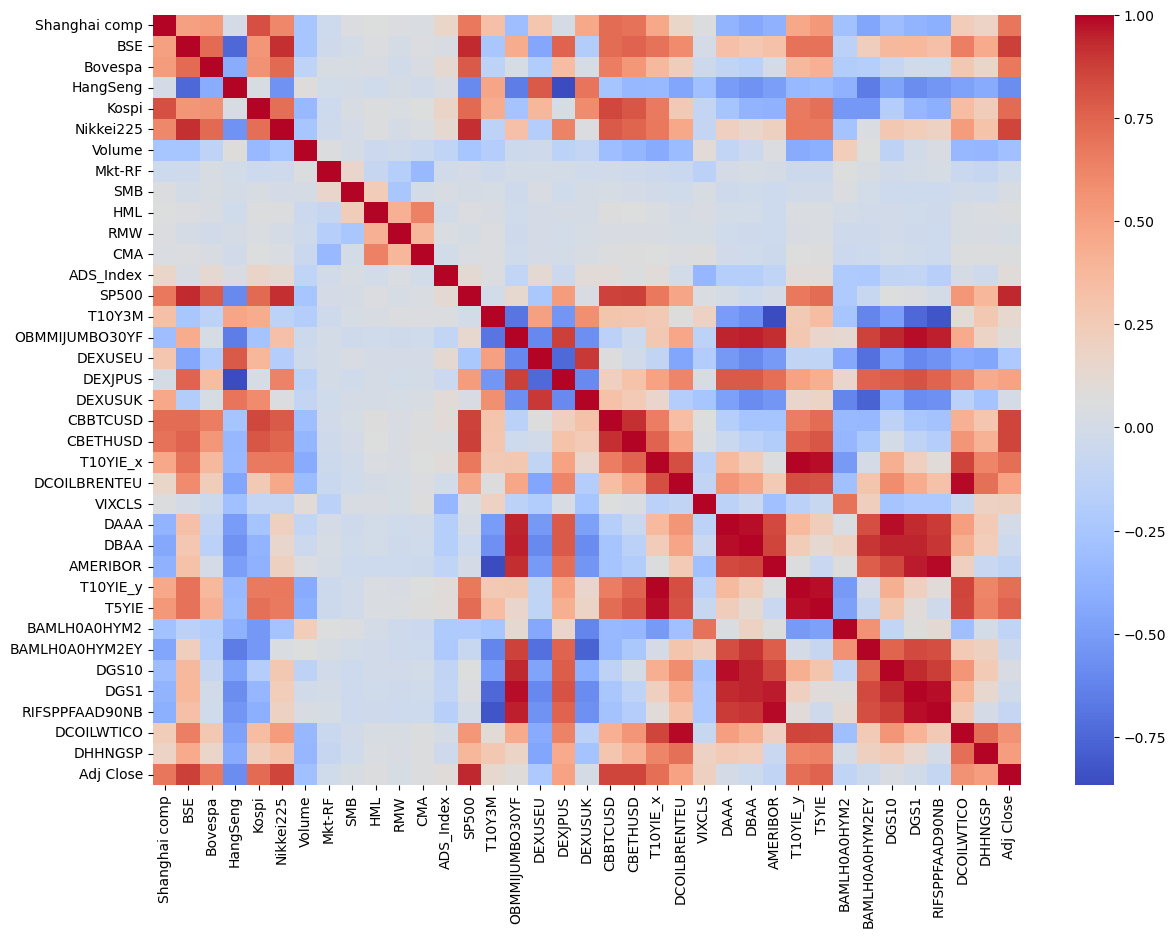

In [6]:
# Correlation matrix
fig=plt.figure(figsize=(14,10))
X=df.drop('Adj Close',axis=1)
y=df['Adj Close']
fig_data=pd.concat([X,y],axis=1)
corr = fig_data.corr()
fig1=sns.heatmap(corr,cmap='coolwarm')
plt.show()

In [7]:
# Linear Regression based factor selection

X=df.drop('Adj Close',axis=1)
y=df['Adj Close']

# y=np.diff(np.log(df['Adj Close'].values))
# X=(X-X.mean(axis=0))/X.std(axis=0)
# y = np.append(y[0], y)

X = sm.add_constant(X)
    
benchmark_prep = sm.OLS(y,X).fit()
print(benchmark_prep.summary())

lr_benchmark_select = X.columns[np.abs(benchmark_prep.tvalues)>=1.96]
x = X[lr_benchmark_select]

benchmark = sm.OLS(y,x).fit()
print(benchmark.summary())

y_hat_benchmark1 = benchmark.predict(x)
corr_benchmark1 = ss.pearsonr(y_hat_benchmark1, y)[0]
print('\nbenchmark: corr (Y, Y_pred) = '+str(corr_benchmark1))
print('Top selected ' +str(len(lr_benchmark_select)) +' features: ', lr_benchmark_select.values)

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     840.5
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        13:47:14   Log-Likelihood:                -4112.6
No. Observations:                 932   AIC:                             8297.
Df Residuals:                     896   BIC:                             8471.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -721.4116     80.610     -8.

In [8]:
# Factors selection using Ridge Regression 
a = 0.5
X=df.drop('Adj Close',axis=1)
y=df['Adj Close']
# X=(X-X.mean(axis=0))/X.std(axis=0)

X = sm.add_constant(X)

model2_prep = linear_model.Ridge(alpha=a, fit_intercept=False).fit(X, y)
rr_model2_select = X.columns[np.abs(model2_prep.coef_)>=0.01]

x = X[rr_model2_select]
model2 = sm.OLS(y,x).fit()
print(model2.summary())

y_pred_model2 = model2.predict(x)
corr_model2 = ss.pearsonr(y_pred_model2, y)[0]

print('\nmodel 2 Ridge Regression: corr (Y, Y_pred) = '+str(corr_model2))
print('Ridge Regression selected ' +str(len(rr_model2_select)) +' features: ', rr_model2_select.values)

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     921.5
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        13:47:14   Log-Likelihood:                -4159.0
No. Observations:                 932   AIC:                             8378.
Df Residuals:                     902   BIC:                             8523.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -596.6223     69.887     -8.

In [9]:
# Random Forest based factor selection
X=df.drop('Adj Close',axis=1)
y=df['Adj Close']

# y=np.diff(np.log(df['Adj Close'].values))
# y=np.append(y[0],y)

features=X.columns

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

rf=RandomForestRegressor(n_estimators=100,
                           criterion='squared_error',
                           max_depth=3,
                           min_samples_split=2,
                           bootstrap=True,
                           random_state=42)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=3, random_state=42)

Feature and Feature Importance:

 SP500 = 0.7800805110436236
CBBTCUSD = 0.13829115622256644
T5YIE = 0.04285533343659015
OBMMIJUMBO30YF = 0.01354420194043757
BSE = 0.008893251279167309
CBETHUSD = 0.006569262095566063
DAAA = 0.0030395830043972827
AMERIBOR = 0.0024999855556087007


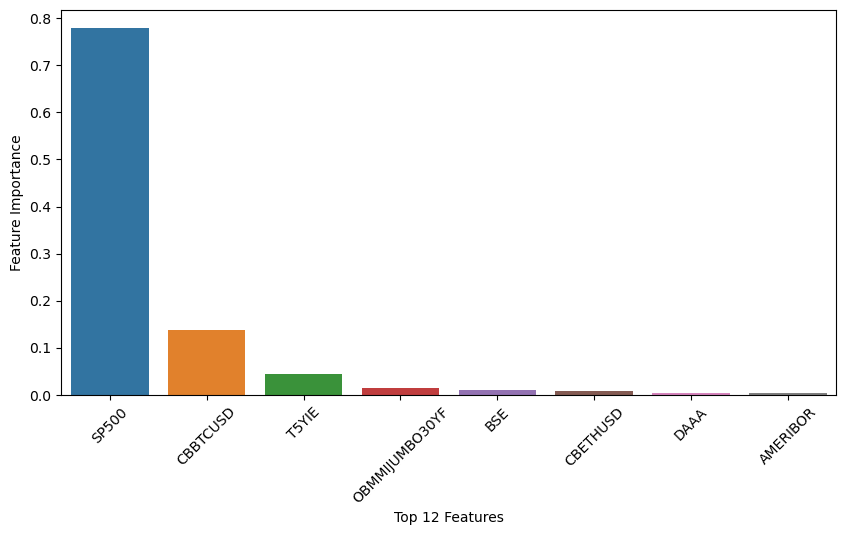

In [10]:
f_i=list(zip(features,rf.feature_importances_))
f_i.sort(key=lambda x:x[1],reverse=True)
f_i=f_i[:8]
rf_model_select=[i[0] for i in f_i]
print('Feature and Feature Importance:\n\n','\n'.join([f"{i[0]} = {i[1]}" for i in f_i]))

fig=plt.figure(figsize=(10,5))
sns.barplot(x=[t[0] for t in f_i],y=[t[1] for t in f_i])
plt.xticks(rotation=45)
plt.xlabel('Top 12 Features')
plt.ylabel('Feature Importance')
plt.show()

In [11]:
lr_benchmark_select=lr_benchmark_select.tolist()
rr_model2_select=rr_model2_select.tolist()

# Feature selected using Linear Regression, Ridge Regression and Random Forest
print(f"Features selected using Linear regression: {lr_benchmark_select}")
print(f"\nFeatures selected using Ridge regression: {rr_model2_select}")
print(f"\nFeatures selected using Random Forest: {rf_model_select}")

Features selected using Linear regression: ['const', 'Shanghai comp', 'BSE', 'Kospi', 'Nikkei225', 'Mkt-RF', 'SP500', 'OBMMIJUMBO30YF', 'DEXUSEU', 'DEXUSUK', 'CBBTCUSD', 'CBETHUSD', 'T10YIE_x', 'VIXCLS', 'DAAA', 'DBAA', 'T10YIE_y', 'BAMLH0A0HYM2', 'BAMLH0A0HYM2EY', 'DGS10', 'DGS1', 'RIFSPPFAAD90NB', 'DCOILWTICO', 'DHHNGSP']

Features selected using Ridge regression: ['const', 'Shanghai comp', 'Kospi', 'Nikkei225', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'ADS_Index', 'SP500', 'T10Y3M', 'OBMMIJUMBO30YF', 'DEXUSEU', 'DEXJPUS', 'DEXUSUK', 'T10YIE_x', 'DCOILBRENTEU', 'VIXCLS', 'DAAA', 'DBAA', 'AMERIBOR', 'T10YIE_y', 'T5YIE', 'BAMLH0A0HYM2', 'BAMLH0A0HYM2EY', 'DGS10', 'DGS1', 'RIFSPPFAAD90NB', 'DCOILWTICO', 'DHHNGSP']

Features selected using Random Forest: ['SP500', 'CBBTCUSD', 'T5YIE', 'OBMMIJUMBO30YF', 'BSE', 'CBETHUSD', 'DAAA', 'AMERIBOR']
